## Network Spanning Trees  —  Minimum & Maximum

* citations/reference
* story
* explanations

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark

2020-03-28T19:09:54-04:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.4.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
import libpysal
from libpysal import cg
from shapely.geometry import LineString
import matplotlib
import matplotlib.pyplot as plt
#import numpy
import spaghetti

import copy

%matplotlib inline
%watermark -w
%watermark -iv

watermark 2.0.2
matplotlib 3.1.2
spaghetti  1.4.2.post2
libpysal   4.2.2
geopandas  0.7.0



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

In [4]:
def network_has_cycle(adjacency):
    """Searches for a cycle in the complete network/graph.
    
    Parameters
    ----------
    adjacency : spaghetti.Network.adjacencylist
        Vertex adjacency relationships.
    
    Returns
    -------
    network_cycle_found : bool
        ``True`` for a cycle being found in the network/graph, 
        otherwise ``False``. 
    """
    
    def tree_has_cycle(_parent, _v):
        """Searches for a cycle in the subtree.

        Parameters
        ----------
        _parent : int
            Root vertex for the subnetwork/graph.
        _v : int
            Current vertex index of in the complete network.

        Returns
        -------
        subtree_cycle_found : bool
            Current recursion found a cycle in the subtree.
        """

        # Set current cycle tag as False
        subtree_cycle_found = False

        # Label the current network vertex as seen  
        seen[_v] = True

        # Perform recursion for all adjacent network/graph vertices 
        for rv in adjacency[_v]: 

            # If vertex already seen, skip it
            if not seen[rv]:
                # Perform recursion down the depth-first search tree
                if tree_has_cycle(_v, rv): 
                    subtree_cycle_found = True
                    break

            # If an adjacent vertex has not been seen and it is not the
            # parent of current vertex, then a cycle is present
            elif _parent != rv: 
                subtree_cycle_found = True
                break

        return subtree_cycle_found
    
    # set initial cycle tag as False
    network_cycle_found = False
    
    # Label all network/graph vertices as not seen 
    vids = list(adjacency.keys())
    seen = {vid:False for vid in vids}
    
    # Perform depth-first search recursion to isolate cycles
    for idx, v in enumerate(vids):
        # If vertex already seen, skip it
        if not seen[v]:
            # Perform recursion down the depth-first search tree
            if tree_has_cycle(-1, v): 
                network_cycle_found = True
                break
    
    return network_cycle_found


def chain_constr(_vcoords, _vs):
    """
    
    Parameters
    ----------
    _vcoords : dict
        See ``vcoords`` in ``get_chains()``.
        
    _vs : tuple
        Start and end vertex IDs of arc.
        
    Returns
    -------
    chain : libpysal.cg.Chain
        Spatial representation of the arc.
    """
    chain = cg.Chain([cg.Point((_vcoords[v])) for v in _vs])
    return chain


def get_chains(vcoords, arcs):
    """Create the spatial representation of a network arc.
    
    Parameters
    ----------
    vcoords : dict
        Vertex to coordinate lookup (see ``spaghetti.Network.vertex_coords``).
    
    arcs : list
        Arcs represented as start and end vertices.
        
    Returns
    -------
    spatial_reps : list
        Spatial representations of arcs - ``libpysal.cg.Chain`` objects.
    """
    spatial_reps = [chain_constr(vcoords, vs) for vs in arcs]
    return spatial_reps


def spanning_tree(net, method="sort", maximum=False, silence_warnings=True):
    """Extract a minimum or maximum spanning tree from a network.
    
    Parameters
    ----------
    net : spaghetti.Network
        Instance of a network object.
    
    method : str
        Method for determining spanning tree. Currently, the only
        supported method is 'sort', which sorts the network arcs
        by length prior to building intermediary networks and checking
        for cycles within the tree/subtrees. Future methods may 
        include linear programming approachs, etc.
    
    maximum : bool
        When ``True`` a maximum spanning tree is created. When ``False``
        a minimum spanning tree is created. Default is ``False``.
    
    silence_warnings : bool
        Warn if there is more than one connected component. Default is
        ``False`` due to the nature of constructing a minimum
        spanning tree.
    
    Returns
    -------
    net : spaghetti.Network
        Pruned instance of the network object.
    
    Notes
    -----
    For in-depth background and details see ... and ...
    
    @article{GrahamHell_1985,
        author = {Graham, R. L. and Hell, Pavol},
        title = {On the History of the Minimum Spanning Tree Problem},
        year = {1985},
        volume = {7},
        number = {1},
        doi = {10.1109/MAHC.1985.10011},
        journal = {IEEE Annals of the History of Computing},
        pages = {43–57}
    }
    
    Ahuja... Network flows...
    
    
    See also
    --------
    
    networkx.algorithms.mst
    scipy.sparse.csgraph.minimum_spanning_tree
    
    
    https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.mst.minimum_spanning_tree.html#networkx.algorithms.mst.minimum_spanning_tree
    https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.sparse.csgraph.minimum_spanning_tree.html
    
    
    Examples
    --------
    
    Create a network instance.
    
    >>>
    >>>
    
    """
    
    # (un)silence warning
    weights_kws = {"silence_warnings":silence_warnings}
    # do not extract graph object while testing for cycles
    net_kws = {"extractgraph":False, "weights_kws":weights_kws}
    
    # if the network has no cycles, it is already a spanning tree
    if network_has_cycle(net.adjacencylist):
        
        if method.lower() == "sort":
            spanning_tree = mst_weighted_sort(net, maximum, net_kws)
        else:
            msg = "'%s' not a valid method for minimum spanning tree creation"
            raise ValueError(msg % method)
        
        # instantiate the spanning tree as a network object
        net = spaghetti.Network(in_data=spanning_tree, weights_kws=weights_kws)
    
    return net


def mst_weighted_sort(net, maximum, net_kws):
    """Extract a minimum or maximum spanning tree from a network used
    the length-weighted sort method.
    
    Parameters
    ----------
    net : spaghetti.Network
        See ``spanning_tree()``.
    maximum : bool
        See ``spanning_tree()``.
    net_kws : dict
        Keywords arguments for instaniating a ``spaghetti.Network``.
    
    Returns
    -------
    spanning_tree : list
        All networks arcs that are members of the spanning tree.
    
    Notes
    -----
    This function is based on the method found in [OKABE... ch. ... 4?]
    """
    
    # network arcs dictionary sorted by arc length
    sort_kws = {"key":net.arc_lengths.get, "reverse":maximum}
    sorted_lengths = sorted(net.arc_lengths, **sort_kws)

    # the spanning tree is initially empty
    spanning_tree = []
    
    # iterate over each lengths of network arc
    while sorted_lengths:
        _arc = sorted_lengths.pop(0)
        # make a spatial representation of an arc
        chain_rep = get_chains(net.vertex_coords, [_arc])
        # current set of network arcs as libpysal.cg.Chain
        _chains = spanning_tree + chain_rep
        # current network iteration
        _ntw = spaghetti.Network(in_data=_chains, **net_kws)
        # determine if the network contains a cycle
        if not network_has_cycle(_ntw.adjacencylist):
            # If no cycle is present, add the arc to the spanning tree
            spanning_tree.extend(chain_rep)
    
    return spanning_tree 
    

In [5]:
def plotter(net_arcs, net_verts, mst_arcs=None, mst_verts=None, label=True):
    """
    """
    plot_mst, msize, vert_z = False, 40, 3
    if hasattr(mst_arcs, "T") and hasattr(mst_verts, "T"):
        plot_mst, msize, vert_z = True, 20, 4
    
    # set arc keyword arguements
    arc_kws = {"column":"comp_label", "cmap":"Paired"}
    
    # set the streets as the plot base
    base_kws = {"figsize":(12, 12)}
    base_kws.update(arc_kws)
    base = net_arcs.plot(lw=5, alpha=.25, **base_kws)
    # create vertices keyword arguments for matplotlib
    ax_kwargs = {"ax":base}
    net_verts.plot(color="k", markersize=msize, zorder=vert_z, **ax_kwargs)
    
    if plot_mst:
        mst_arcs.plot(color="k", lw=3, zorder=2, alpha=.5, **ax_kwargs)
        mst_verts.plot(color="r", markersize=100, zorder=3, **ax_kwargs)
    
    if label:
        if not plot_mst:
            # arc labels
            arc_labels(net_arcs, base, 12)
            # vertex labels
            vert_labels(net_verts, base, 14)
        else:
            arc_labels(mst_arcs, base, 12)
            # vertex labels
            vert_labels(mst_verts, base, 14)

def arc_labels(a, b, s):
    """Label each leg of the tour."""
    def _lab_loc(_x):
        """Helper for labeling location."""
        return _x.geometry.interpolate(0.5, normalized=True).coords[0]
    kws = {"size": s, "ha": "center", "va": "bottom"}
    a.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

def vert_labels(v, b, s):
    """Label each point pattern observation."""
    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]
    kws = {"size": s, "ha": "left", "va": "bottom", "weight": "bold"}
    v.apply(lambda x: b.annotate(s=x.id, xy=_lab_loc(x), **kws), axis=1)

---------------------

In [6]:
# exterior
lines = [LineString(((0,0), (0,3)))]
lines += [LineString(((0,3), (4,0)))]
lines += [LineString(((4,0), (0,0)))]
lines = geopandas.GeoDataFrame(geometry=lines)

In [7]:
ntw = spaghetti.Network(in_data=lines)
elem_kws = {"vertices":True, "arcs":True}
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

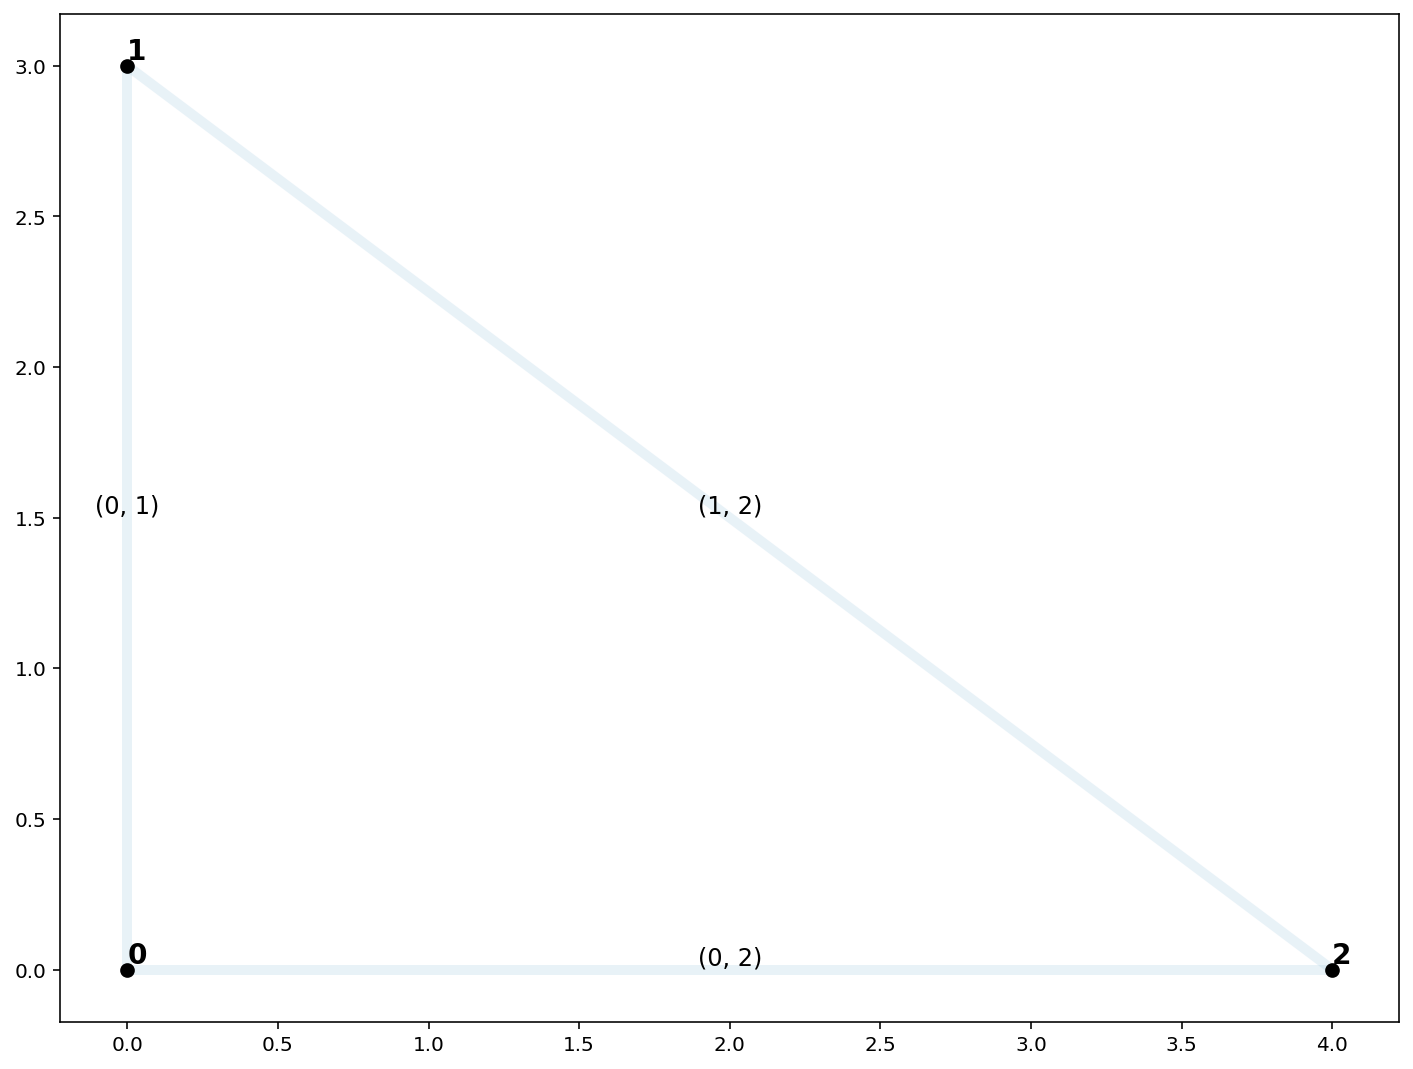

In [8]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

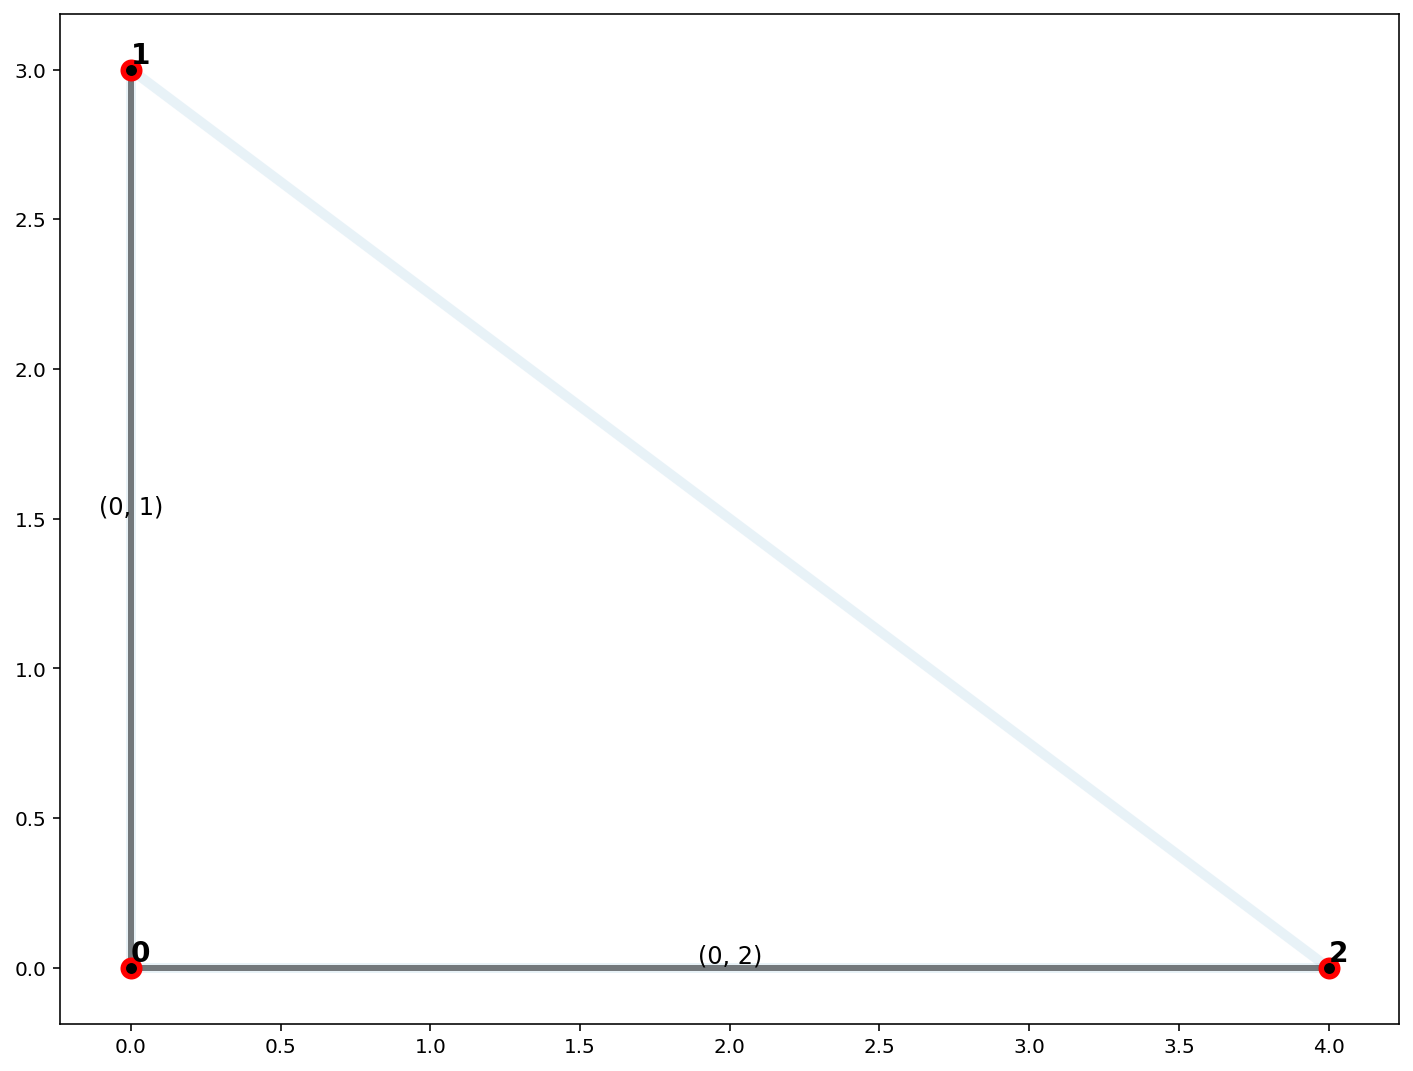

In [9]:
minst_net = spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

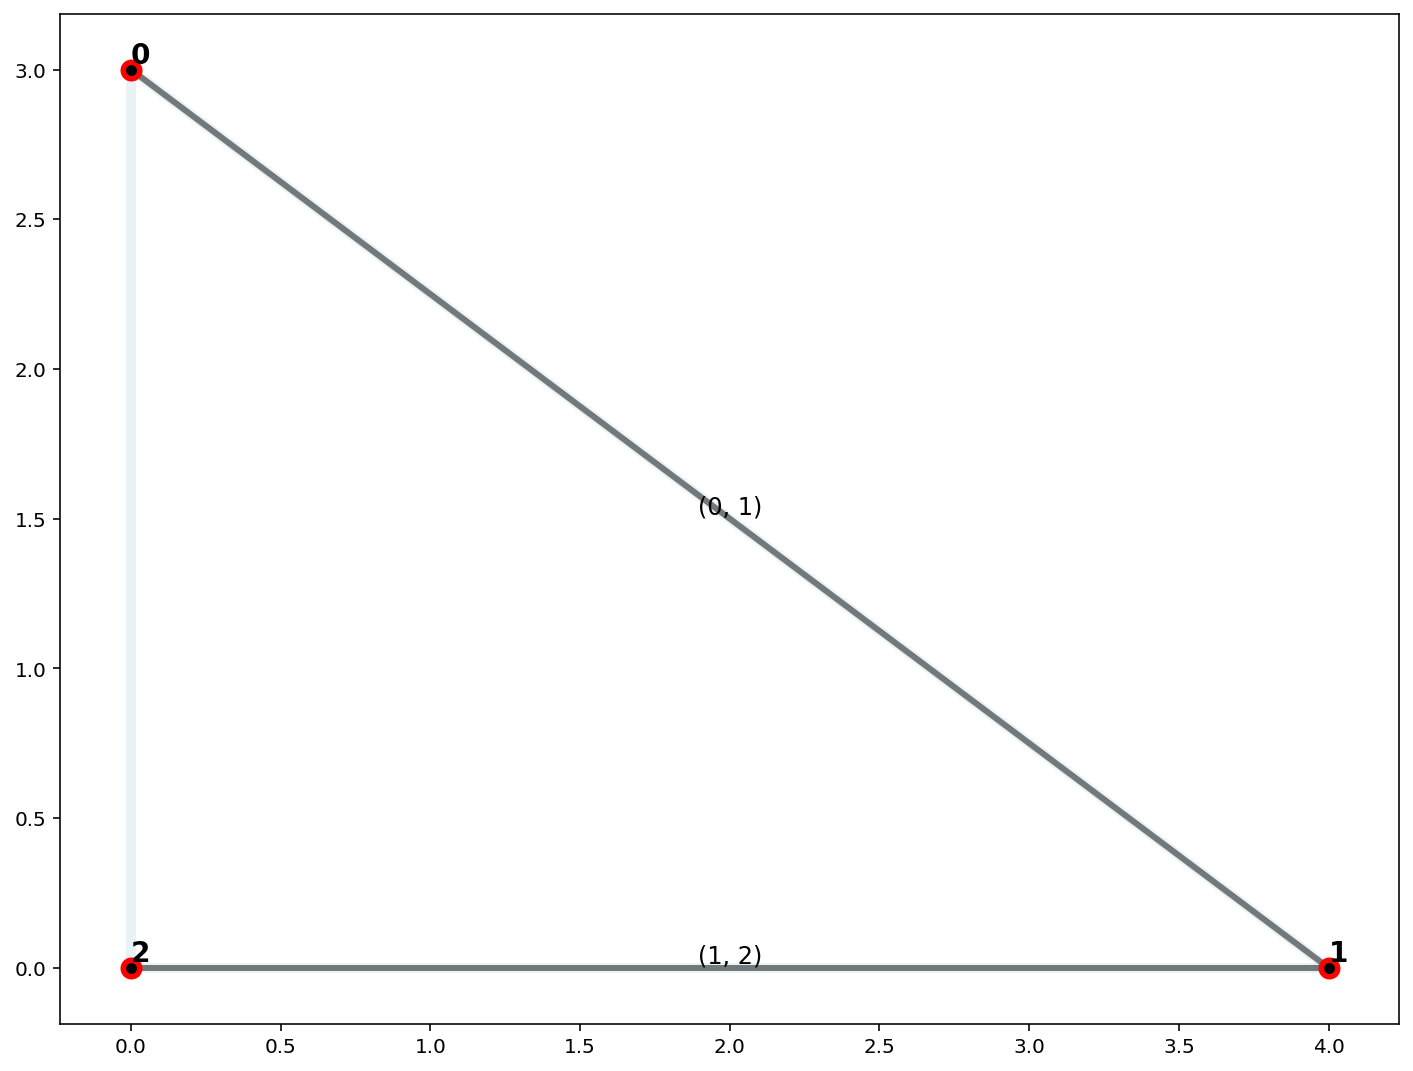

In [10]:
maxst_net = spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

---------------

In [11]:
# exterior
lines = [LineString(((0,0), (0,5)))]
lines += [LineString(((0,5), (10,5)))]
lines += [LineString(((10,5), (10,0)))]
lines += [LineString(((10,0), (0,0)))]
# interior
lines += [LineString(((0,5), (3,4)))]
lines += [LineString(((3,4), (0,0)))]
lines += [LineString(((3,4), (5,4)))]
lines += [LineString(((5,4), (10,5)))]
lines += [LineString(((5,4), (10,0)))]
lines = geopandas.GeoDataFrame(geometry=lines)

In [12]:
ntw = spaghetti.Network(in_data=lines)
elem_kws = {"vertices":True, "arcs":True}
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

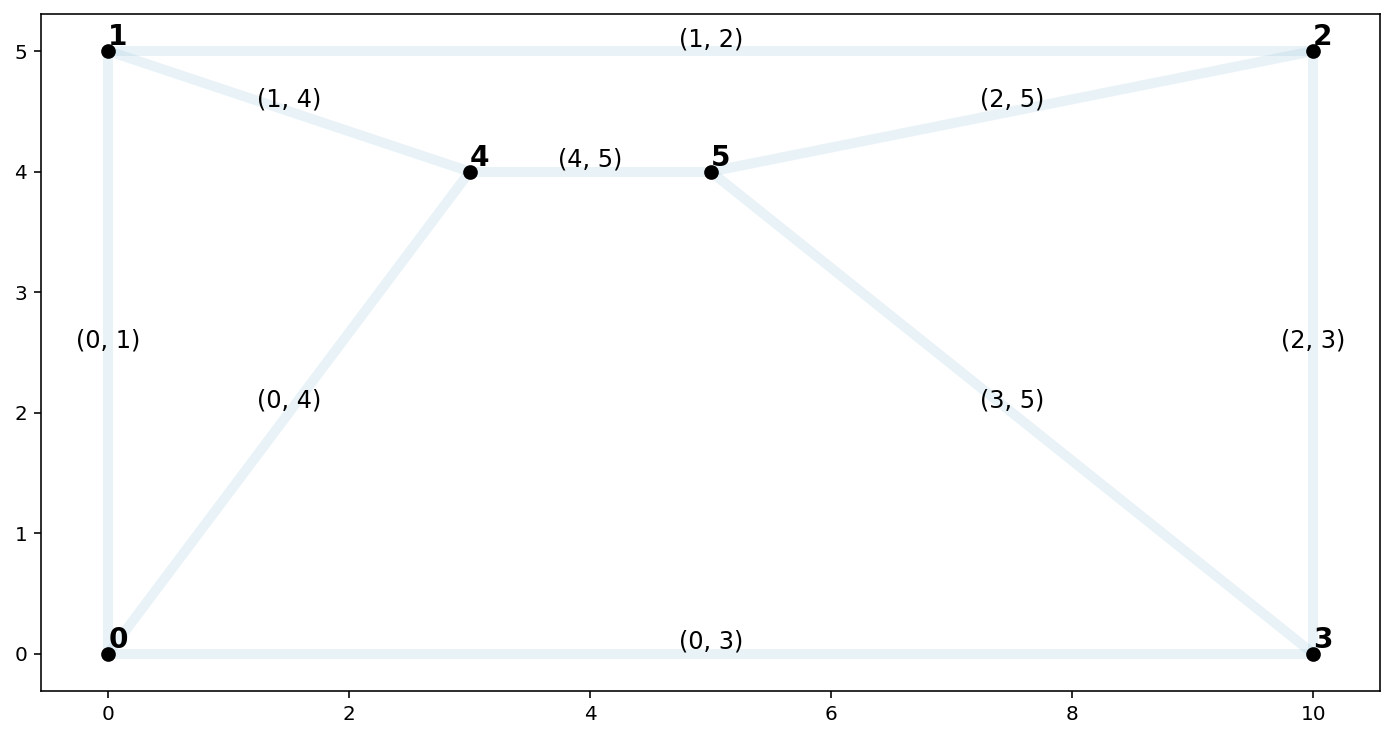

In [13]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

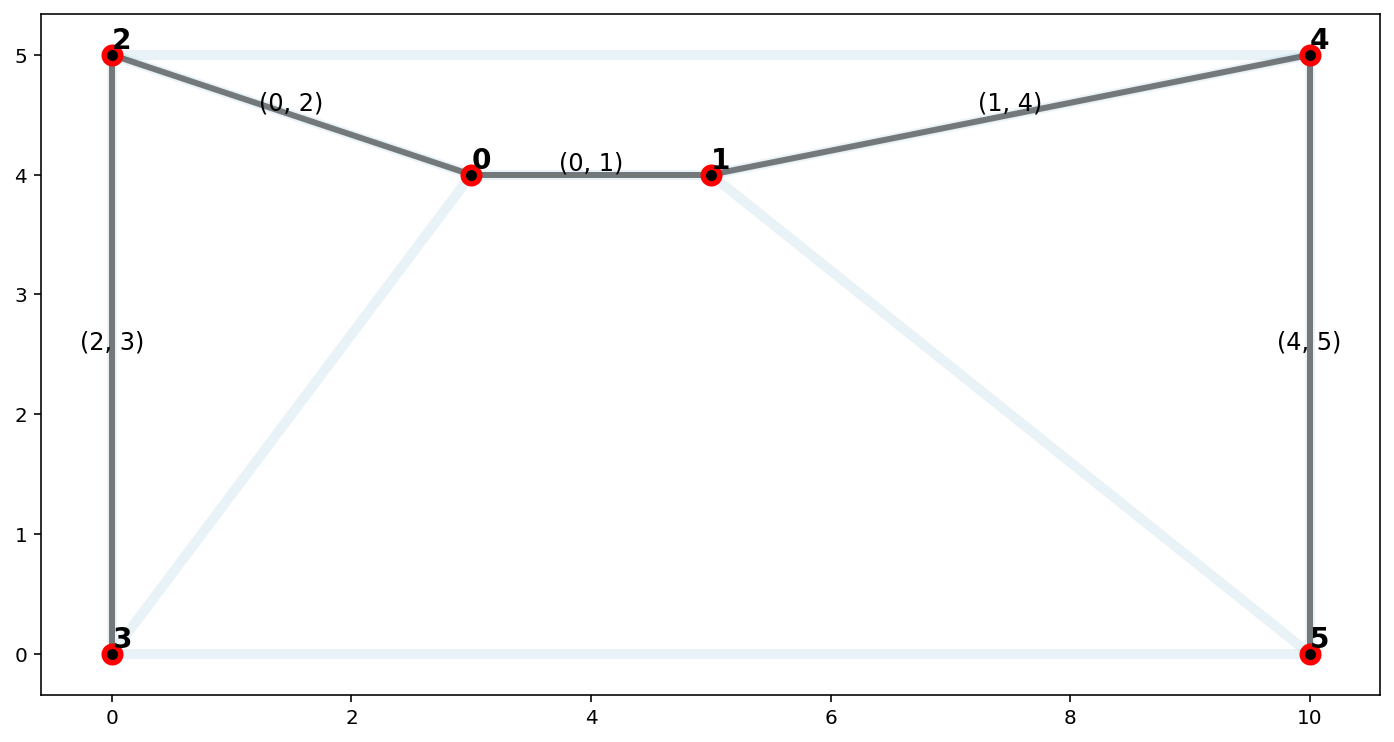

In [14]:
minst_net = spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

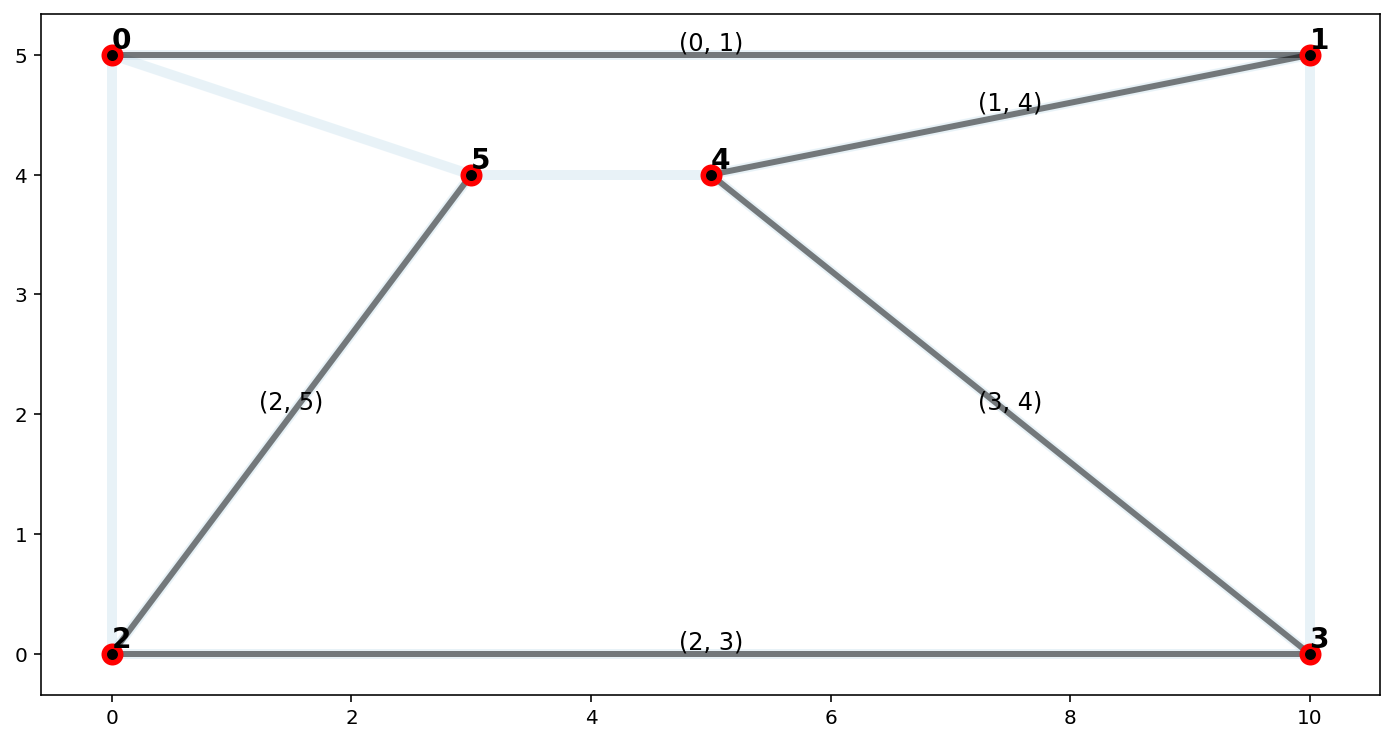

In [15]:
maxst_net = spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

--------------------

In [16]:
bounds = (0,0,3,3)
h, v = 2, 2
lattice = spaghetti.regular_lattice(bounds, h, nv=v, exterior=True)
ntw = spaghetti.Network(in_data=lattice)
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

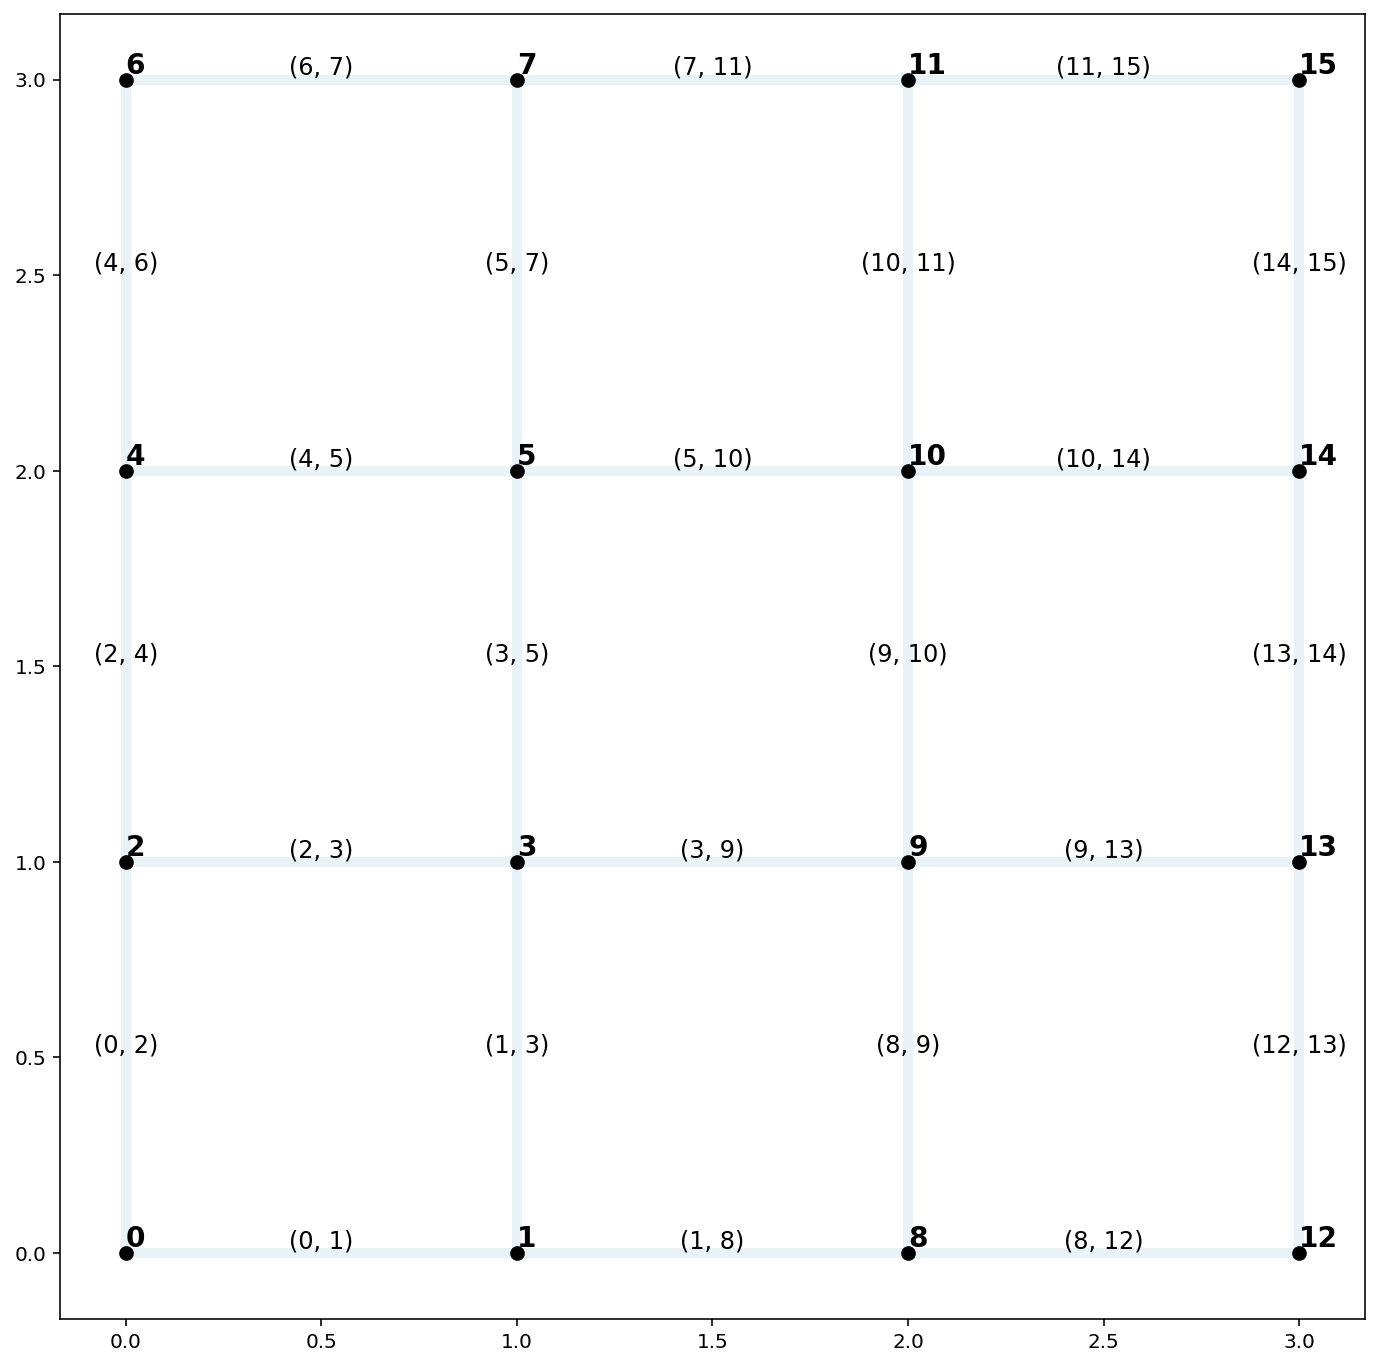

In [17]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None)

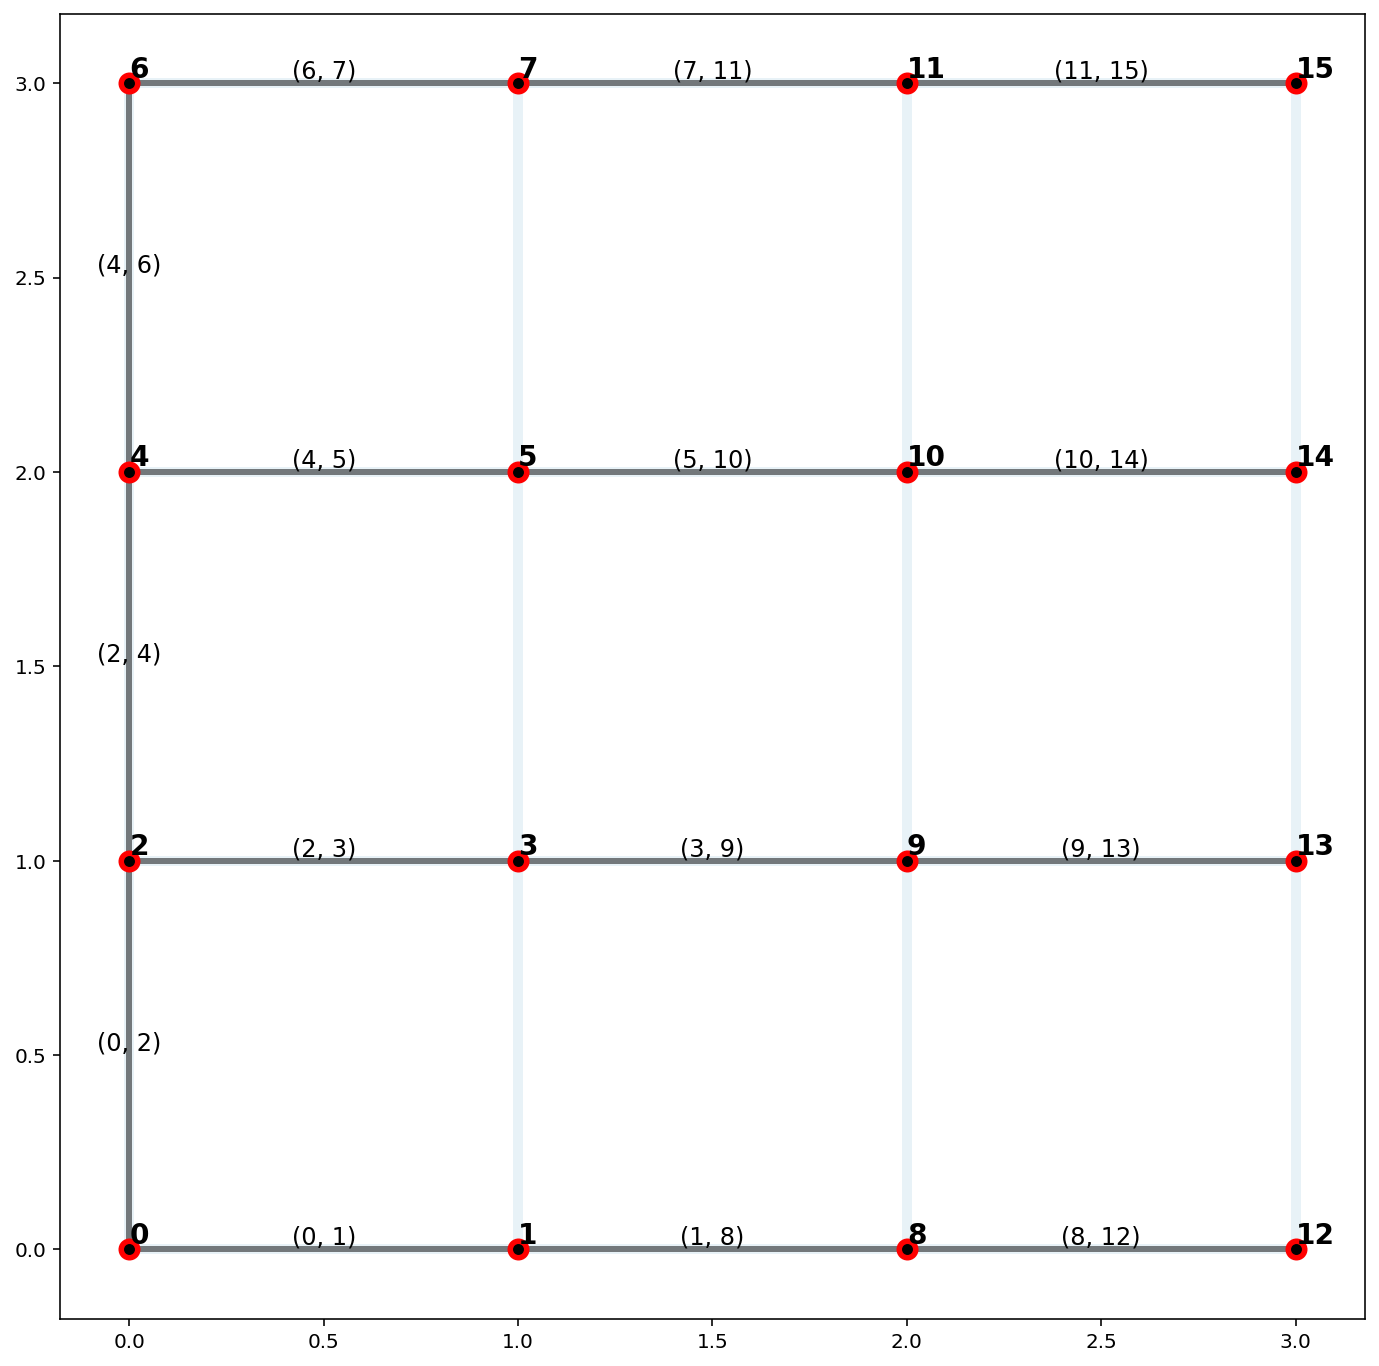

In [18]:
minst_net = spanning_tree(ntw, maximum=False)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

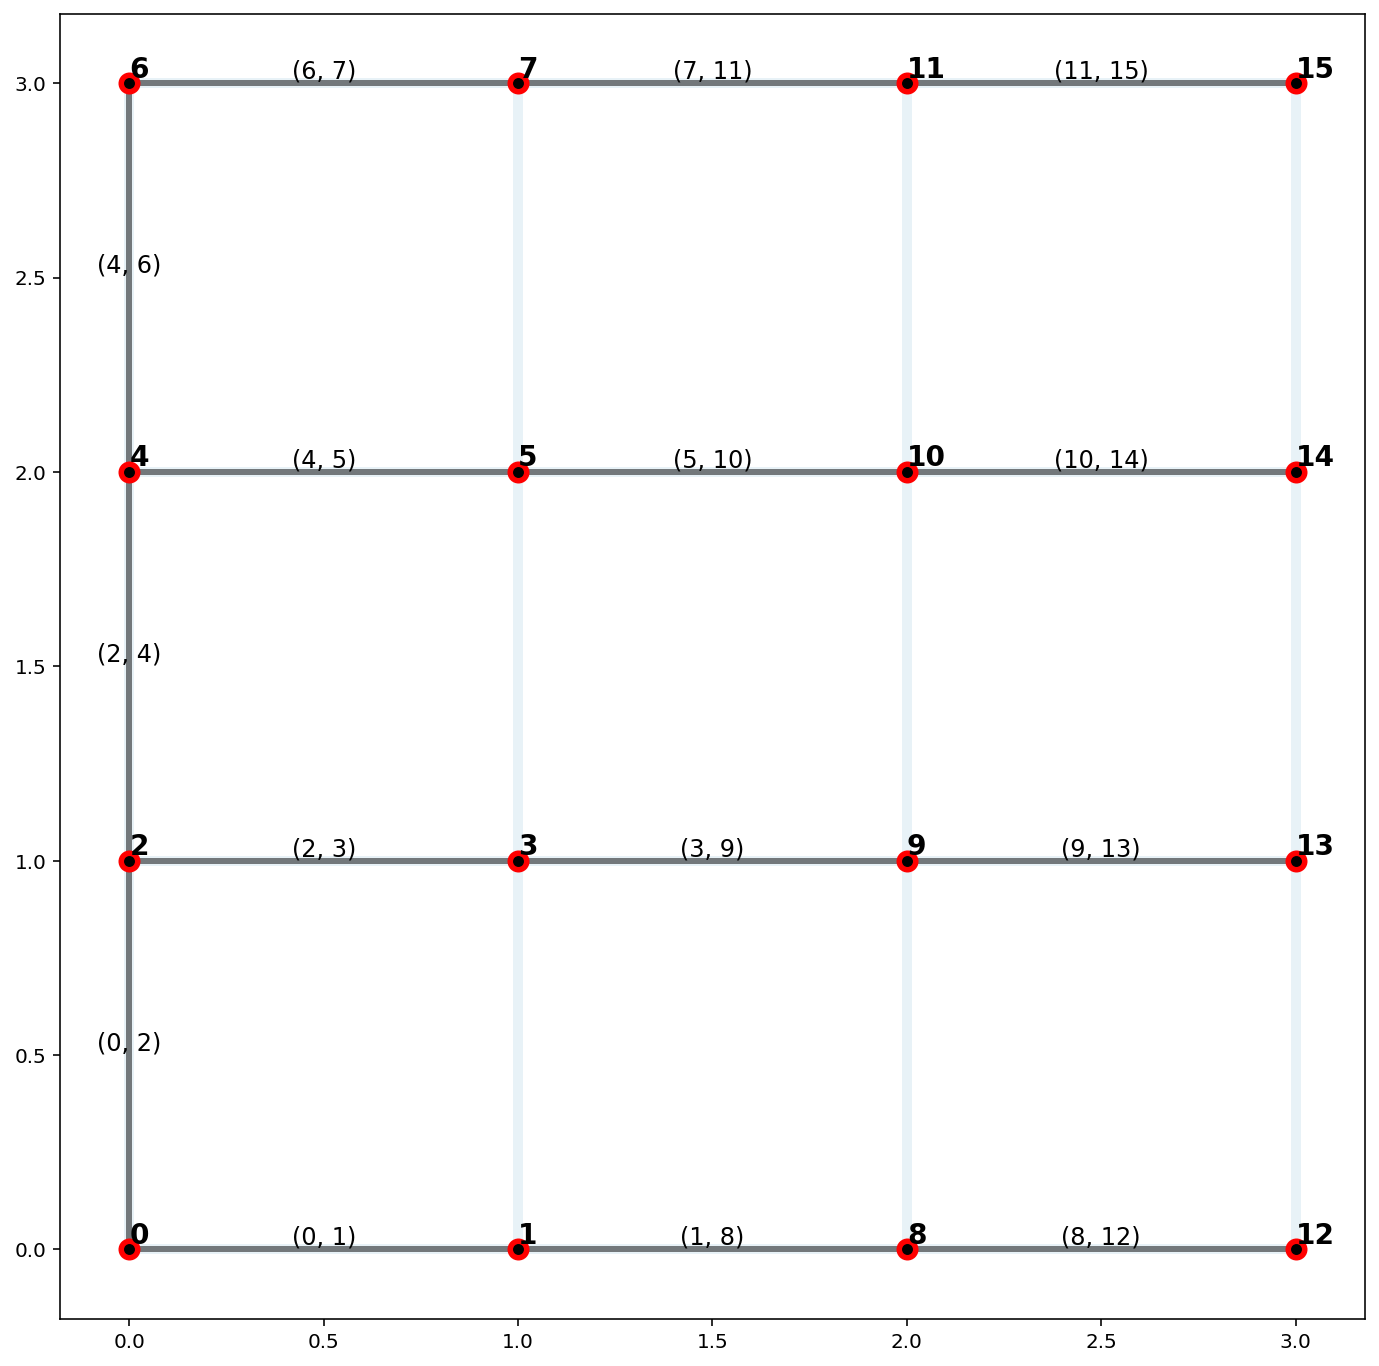

In [19]:
maxst_net = spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts)

-------------------------

In [20]:
ntw = spaghetti.Network(in_data=libpysal.examples.get_path("streets.shp"))
vertices, arcs = spaghetti.element_as_gdf(ntw, **elem_kws)

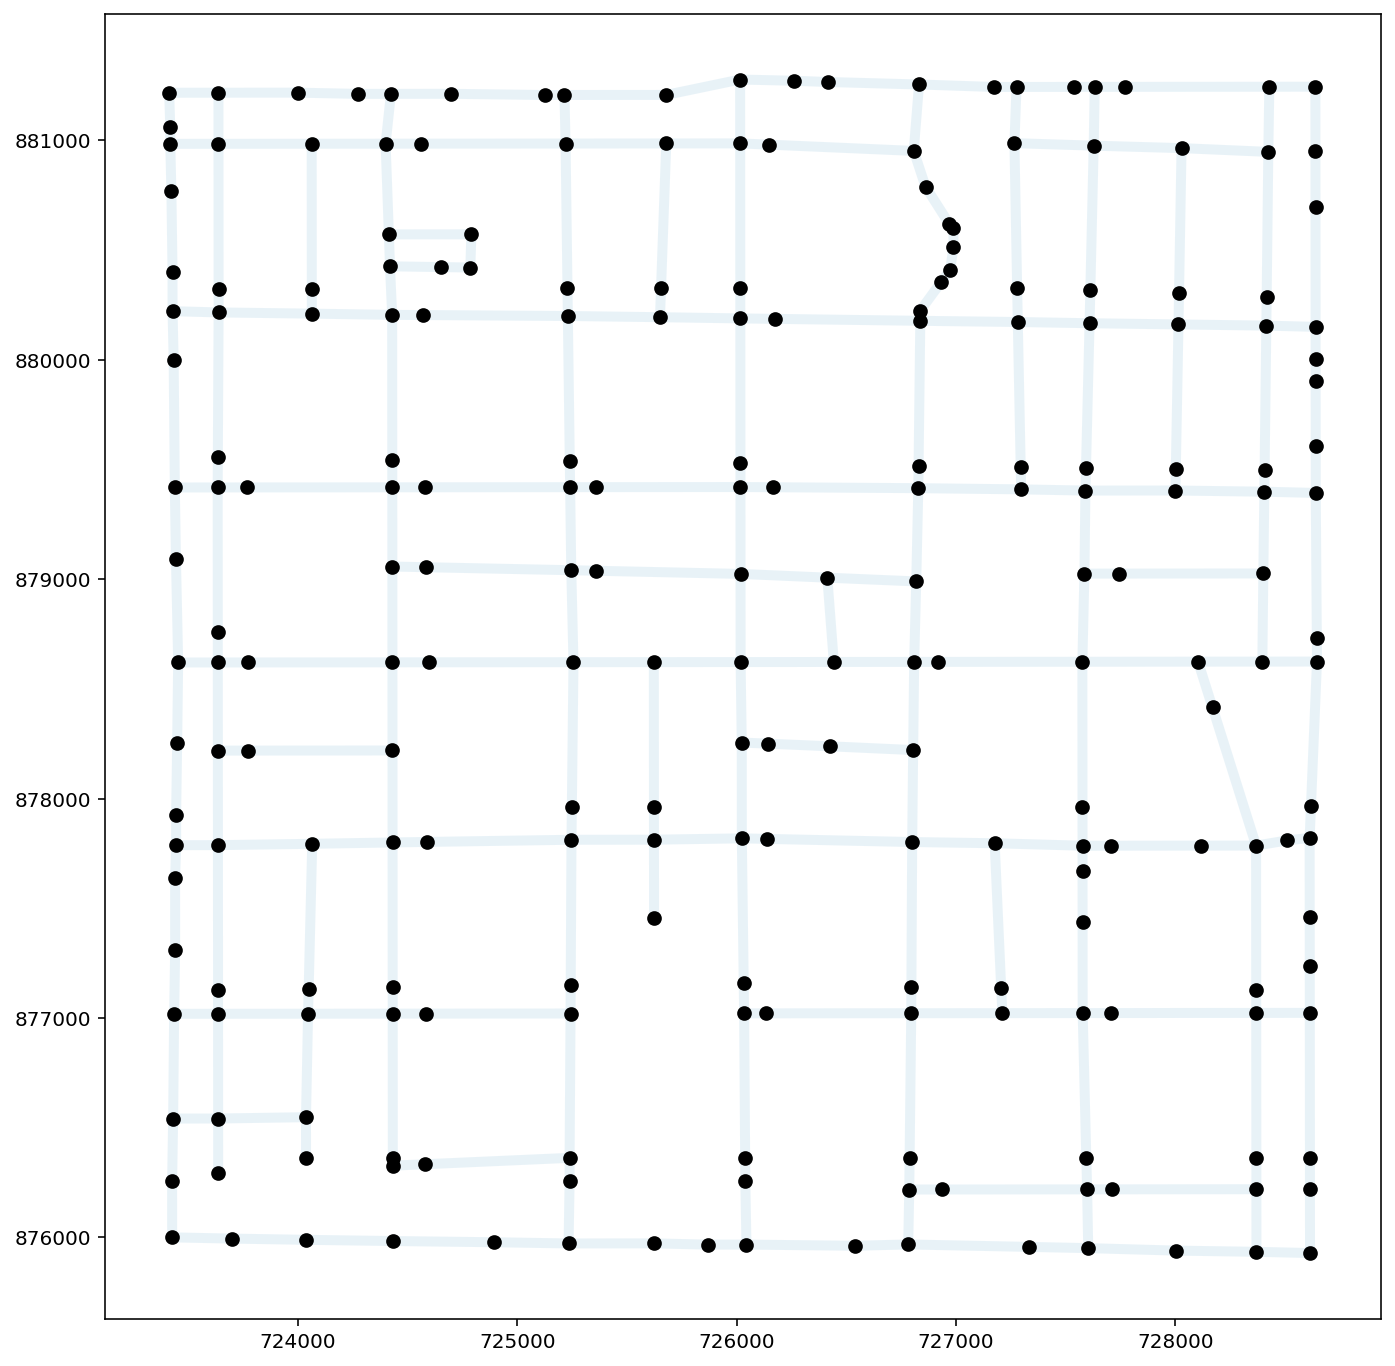

In [21]:
plotter(arcs, vertices, mst_arcs=None, mst_verts=None, label=False)

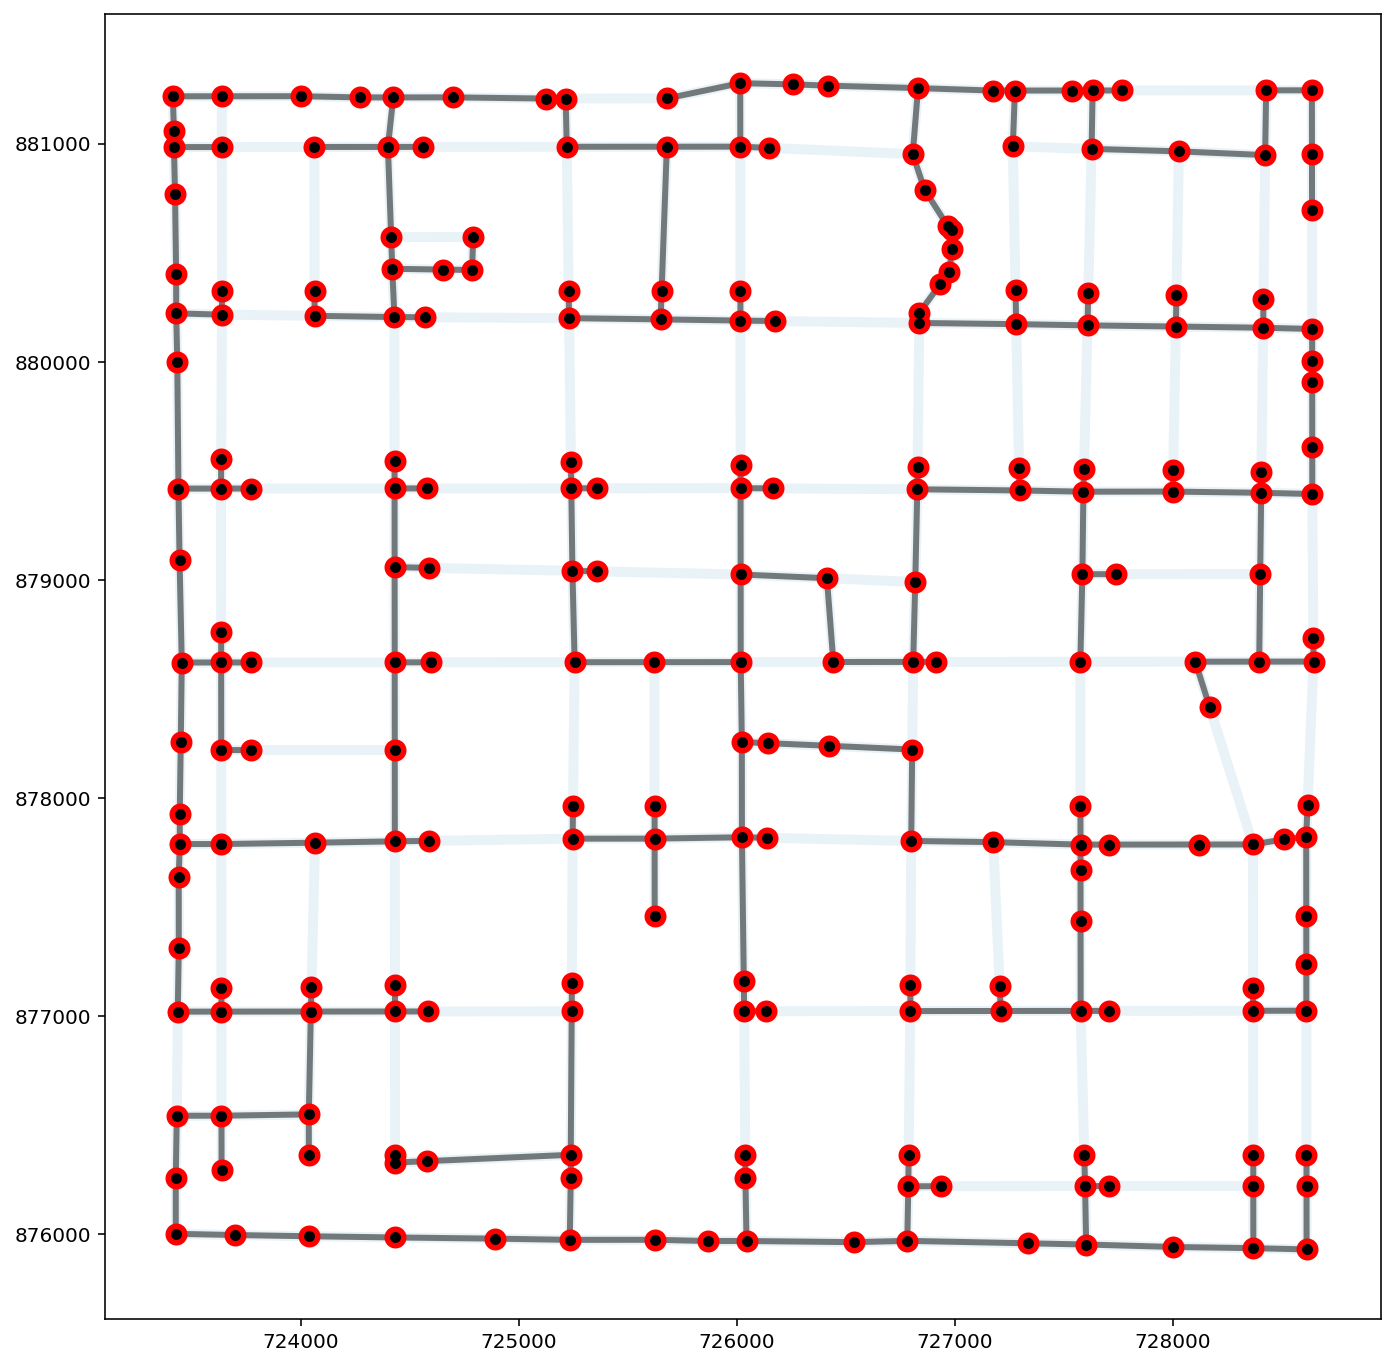

In [22]:
minst_net = spanning_tree(ntw)
mst_verts, mst_arcs = spaghetti.element_as_gdf(minst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts, label=False)

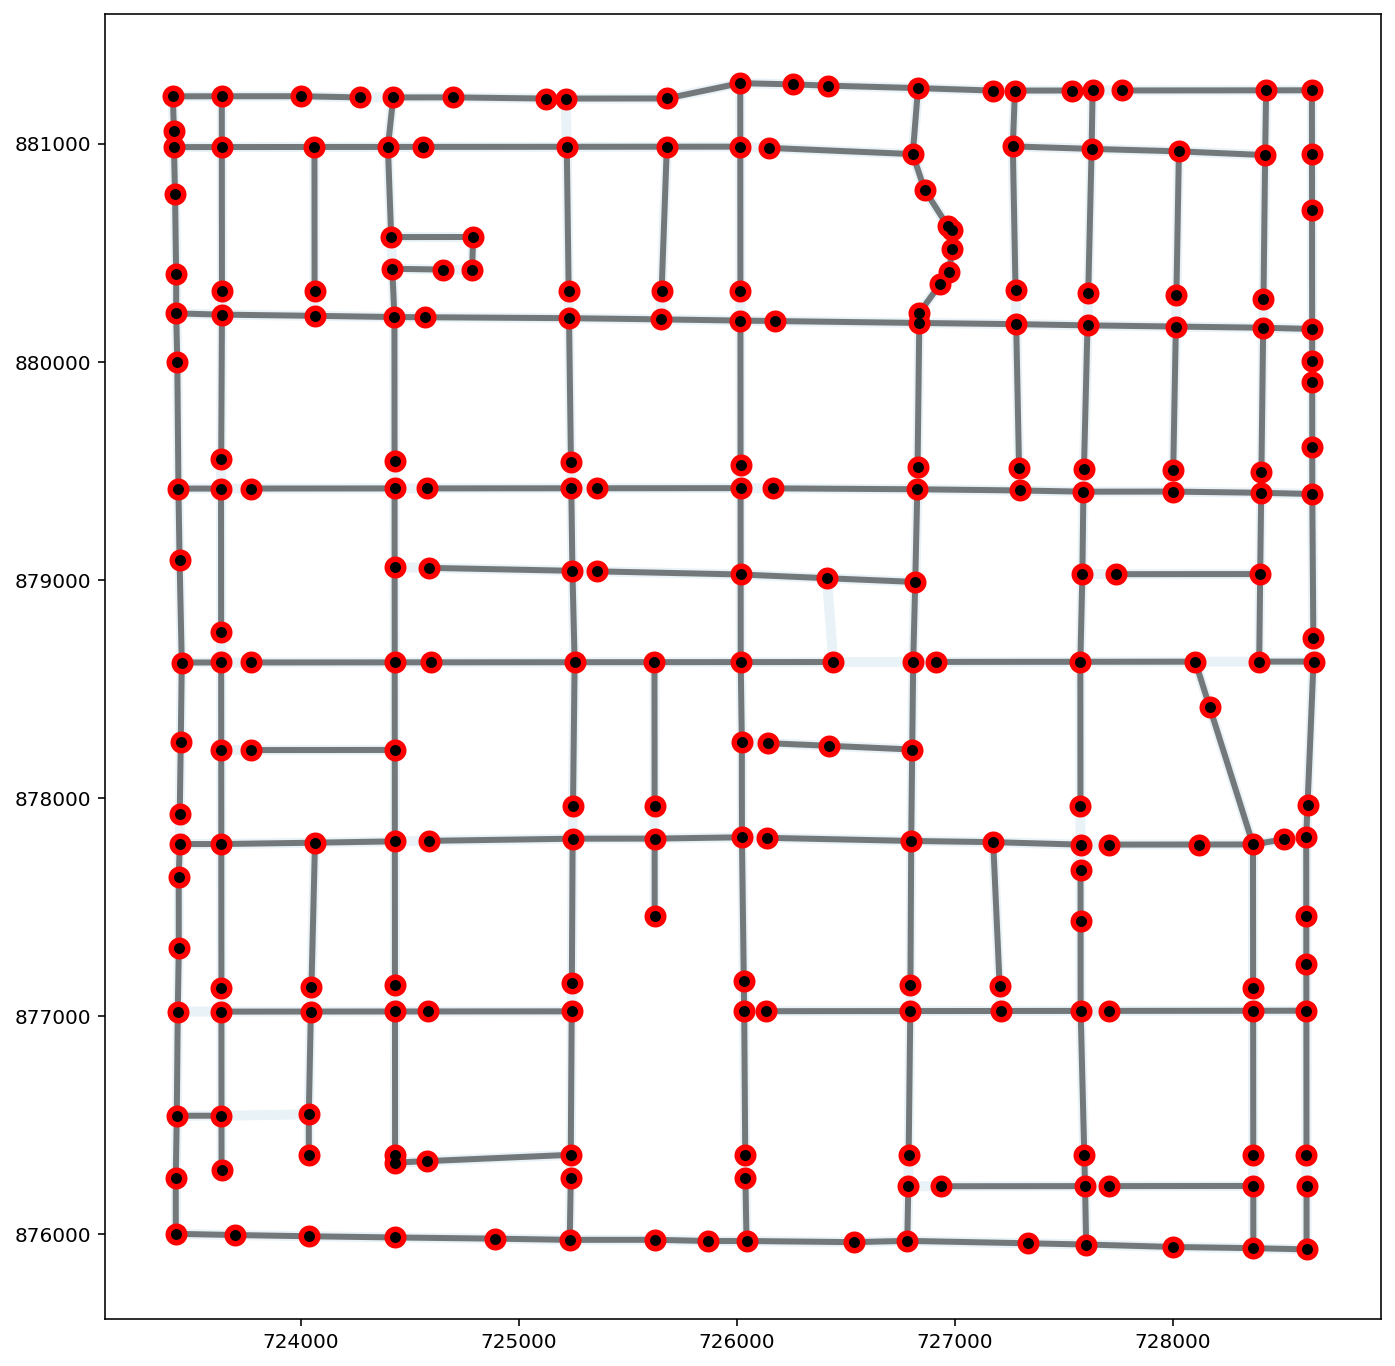

In [23]:
maxst_net = spanning_tree(ntw, maximum=True)
mst_verts, mst_arcs = spaghetti.element_as_gdf(maxst_net, **elem_kws)
plotter(arcs, vertices, mst_arcs=mst_arcs, mst_verts=mst_verts, label=False)

--------------